In [1]:
%load_ext autoreload
%autoreload 2

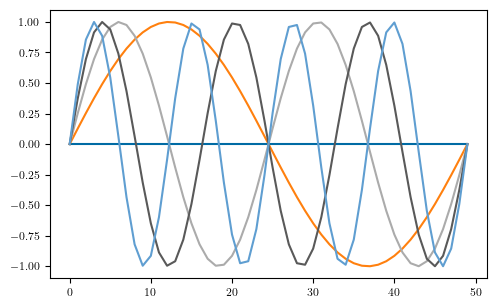

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = path.join("report", "figures")
STYLE_PATH = path.join("report", "thesis.mplstyle")

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name, format="pgf"):
    return path.join(FIGURES_PATH, f"{name}.{format}")

plt.style.use(["default", "tableau-colorblind10", STYLE_PATH])
plt.figure(figsize=figsize())
for i in range(5):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()


Environments.

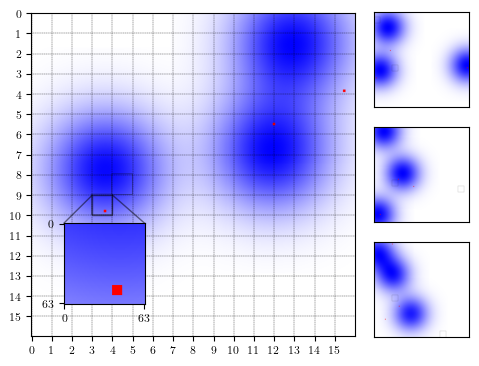

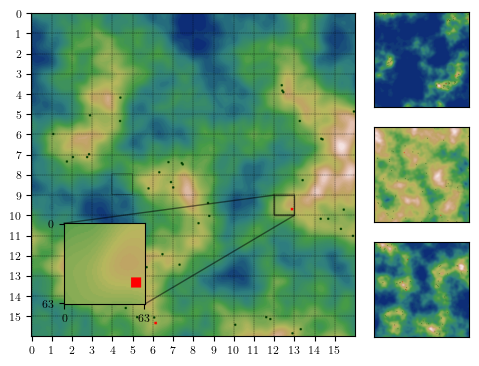

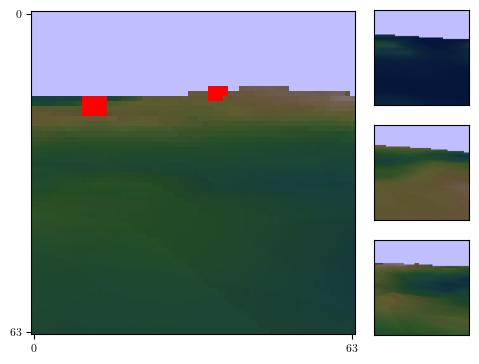

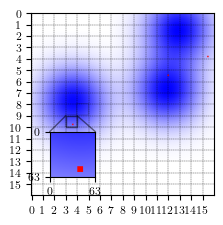

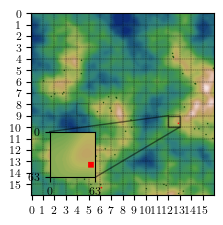

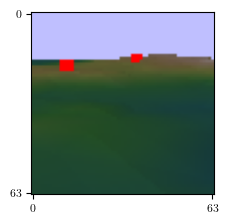

In [10]:
import gym
import gym_search

REPORT_LAYOUT = [
    [0, 0, 0, 1],
    [0, 0, 0, 2],
    [0, 0, 0, 3],
]

SLIDES_LAYOUT = [[0]]

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH

def plot_environment(env_id, seed=0, position=None, layout=REPORT_LAYOUT, width=TEXTWIDTH_IN):
    layout = np.array(layout)
    flattened = layout.flatten()
    unique = set(flattened)
    count = len(unique)
    ratio = layout.shape[0]/layout.shape[1]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=ratio, width=width))
    env = gym.make(env_id)

    for i in range(count):
        env.reset(seed=seed if i == 0 else None)
        env.plot(axs[i], overlay=(i == 0), position=position)

    #fig.tight_layout()

    return fig

plot_environment("Gaussian-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([9, 3])).savefig(figpath("gaussian", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([9, 12])).savefig(figpath("terrain", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([9, 3])).savefig(figpath("camera", format="pgf"), dpi=300, bbox_inches='tight')

plot_environment("Gaussian-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([9, 3])).savefig(figpath("gaussian", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([9, 12])).savefig(figpath("terrain", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([9, 3])).savefig(figpath("camera", format="pdf"), dpi=300, bbox_inches='tight')

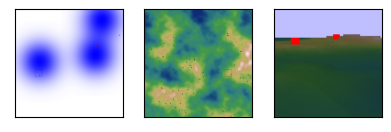

In [13]:
import gym
import gym_search

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH
LAYOUT = [[0, 1, 2]]
ENV_IDS = ["Gaussian-v0", "Terrain-v0", "Camera-v0"]
SEEDS = [0, 0, 0]
POSITIONS = [np.array([9, 3]), np.array([9, 12]), np.array([9, 3])]
RATIO = 1.0/len(LAYOUT)

fig, axs = plt.subplot_mosaic(LAYOUT, figsize=figsize(ratio=RATIO, width=SLIDES_TEXTWIDTH_IN))
envs = [gym.make(env_id) for env_id in ENV_IDS]

for i in range(len(ENV_IDS)):
    ax, env, seed, position = axs[i], envs[i], SEEDS[i], POSITIONS[i]
    env.reset(seed=seed)
    env.plot(ax, overlay=False, position=position)

fig.savefig(figpath("environments", format="pdf"), dpi=300, bbox_inches='tight')

Scalars.

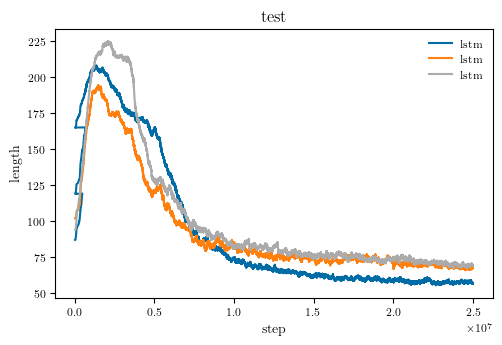

In [14]:
from glob import glob
from scipy import stats
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator, STORE_EVERYTHING_SIZE_GUIDANCE
from functools import lru_cache


def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []

    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

def load_tfevents_scalars(events, tag):
    event_acc = EventAccumulator(events, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    event_acc.Reload()
    scalars = event_acc.Scalars(tag)
    df = pd.DataFrame(scalars)
    return df


def plot_tboard(data, tag, xlabel="step", ylabel="value", smoothing=0.0, original=False, outliers=False, initial=0, mean=True, std=True):
    fig, ax = plt.subplots(figsize=figsize())

    for label, runs in data.items():
        for path in runs:
            df = load_tfevents_scalars(path, tag)

            if not outliers:
                df = df[(np.abs(stats.zscore(df["value"])) < 3)]
            
            df = df[df.step >= initial]

            x = df["step"]
            y = df["value"]

            p = ax.plot(x, smooth(list(y), smoothing), label=label)
            
            if original:
                ax.plot(x, y, alpha=0.25, color=p[0].get_color())

        if mean:
            

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title("test")
    ax.legend(frameon=False)
    
    return fig

data = {
    "lstm": [f"logs/train/map/shape/s/r1/{seed}" for seed in range(1, 4)],
}

fig = plot_tboard(data, "episode/length", ylabel="length", smoothing=0.999, initial=2500)

In [15]:
df1 = load_tfevents_scalars("logs/train/map/shape/s/r1/1", "episode/length")
df2 = load_tfevents_scalars("logs/train/map/shape/s/r1/2", "episode/length")
df3 = load_tfevents_scalars("logs/train/map/shape/s/r1/3", "episode/length")

In [16]:
df1.head()

,wall_time,step,value
0,1.651246e+09,22272,87.0
1,1.651246e+09,23040,90.0
2,1.651246e+09,24320,95.0
3,1.651246e+09,40192,157.0
4,1.651246e+09,44800,175.0


In [17]:
df2.head()

,wall_time,step,value
0,1.651259e+09,26112,102.0
1,1.651259e+09,28672,112.0
2,1.651259e+09,45824,179.0
3,1.651259e+09,46336,181.0
4,1.651259e+09,50176,196.0


Neural networks.

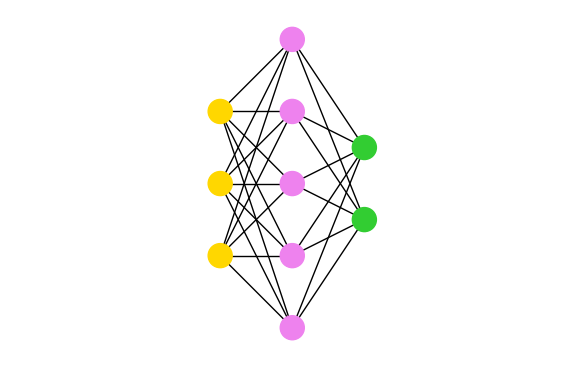

In [12]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx


def plot_ann():
    nodes = [3, 5, 2]
    colors = ["gold", "violet", "limegreen", "violet", "limegreen", "darkorange"]
    extents = nx.utils.pairwise(itertools.accumulate((0,) + tuple(nodes)))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    
    color = [colors[data["layer"]] for v, data in G.nodes(data=True)]
    pos = nx.multipartite_layout(G, subset_key="layer")
    plt.figure(figsize=figsize())
    nx.draw(G, pos, node_color=color, with_labels=False)
    plt.axis("equal")

plot_ann()

Latent image representations.

In [1]:
import torch as th
import numpy as np
from sklearn.decomposition import PCA

import rl
import gym
import gym_search

def image_decomposition(x):
    h, w, c = x.shape
    if c == 3: return x
    x = x.flatten().reshape(h*w, c)
    pca = PCA(n_components=3).fit(x)
    y = pca.transform(x)
    img = y.reshape(h, w, 3)
    img *= (255.0/img.max())
    return np.abs(img)

#device = th.device("cpu")
#envs = gym.vector.make("Terrain-v0", num_envs=1)
#agent = th.load("models/baseline-small.pt").to(device)
#obs = envs.reset()

Metrics (SPL, length).

In [4]:
import pandas as pd

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator, STORE_EVERYTHING_SIZE_GUIDANCE

def load_tfevents_hists(path, tag):
    event_acc = EventAccumulator(path, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    event_acc.Reload()
    events = event_acc.CompressedHistograms(tag)
    print(events)
    df = pd.DataFrame(events)
    return df


load_tfevents_hists("old/test/2022-04-25T16:41:37.639955", "metric/spl").head()

"""
algorithms = ["random", "greedy", "lstm", "spatial"]
scores_dict = {

}

aggregate_func = lambda x: np.array([metrics.aggregate_median(x), metrics.aggregate_iqm(x), metrics.aggregate_mean(x), metrics.aggregate_optimality_gap(x)])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(scores_dict, aggregate_func, reps=50000)

fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean', 'Optimality Gap'],
  algorithms=scores_dict.keys,
  xlabel='SPL'
)
"""

[CompressedHistogramEvent(wall_time=1650897780.7403946, step=0, compressed_histogram_values=[CompressedHistogramValue(basis_point=0, value=0.009855072463768115), CompressedHistogramValue(basis_point=668, value=0.06380064442591273), CompressedHistogramValue(basis_point=1587, value=0.08083616117124762), CompressedHistogramValue(basis_point=3085, value=0.0980641021616335), CompressedHistogramValue(basis_point=5000, value=0.118604439389243), CompressedHistogramValue(basis_point=6915, value=0.1395079324942136), CompressedHistogramValue(basis_point=8413, value=0.1768765808553687), CompressedHistogramValue(basis_point=9332, value=0.24752062374830255), CompressedHistogramValue(basis_point=10000, value=1.0)])]


'\nalgorithms = ["random", "greedy", "lstm", "spatial"]\nscores_dict = {\n\n}\n\naggregate_func = lambda x: np.array([metrics.aggregate_median(x), metrics.aggregate_iqm(x), metrics.aggregate_mean(x), metrics.aggregate_optimality_gap(x)])\naggregate_scores, aggregate_score_cis = rly.get_interval_estimates(scores_dict, aggregate_func, reps=50000)\n\nfig, axes = plot_utils.plot_interval_estimates(\n  aggregate_scores, aggregate_score_cis,\n  metric_names=[\'Median\', \'IQM\', \'Mean\', \'Optimality Gap\'],\n  algorithms=scores_dict.keys,\n  xlabel=\'SPL\'\n)\n'

### Aggregate metrics with 95% Stratified Bootstrap CIs

In [ ]:
# IQM, Optimality Gap, Median, Mean

algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'Rainbow',
              'IQN', 'M-IQN', 'DreamerV2']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
atari_200m_normalized_score_dict = ...
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x)])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  atari_200m_normalized_score_dict, aggregate_func, reps=50000)
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean', 'Optimality Gap'],
  algorithms=algorithms, xlabel='Human Normalized Score')

# Probability of Improvement

# Load ProcGen scores as a dictionary containing pairs of normalized score
# matrices for pairs of algorithms we want to compare
procgen_algorithm_pairs = {.. , 'x,y': (score_x, score_y), ..}
average_probabilities, average_prob_cis = rly.get_interval_estimates(
  procgen_algorithm_pairs, metrics.probability_of_improvement, reps=2000)
plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)

### Sample Efficiency

In [ ]:
algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'Rainbow',
              'IQN', 'M-IQN', 'DreamerV2']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices across all 200 million frames, each of which is of size
# `(num_runs x num_games x 200)` where scores are recorded every million frame.
ale_all_frames_scores_dict = ...
frames = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1
ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in ale_all_frames_scores_dict.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  ale_frames_scores_dict, iqm, reps=50000)
plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Number of Frames (in millions)',
    ylabel='IQM Human Normalized Score')

### Performance Profiles

In [ ]:
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
atari_200m_normalized_score_dict = ...
# Human normalized score thresholds
atari_200m_thresholds = np.linspace(0.0, 8.0, 81)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    atari_200m_normalized_score_dict, atari_200m_thresholds)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
  score_distributions, atari_200m_thresholds,
  performance_profile_cis=score_distributions_cis,
  colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'Human Normalized Score $(\tau)$',
  ax=ax)

# with non-linear scaling
plot_utils.plot_performance_profiles(
  perf_prof_atari_200m, atari_200m_tau,
  performance_profile_cis=perf_prof_atari_200m_cis,
  use_non_linear_scaling=True,
  xticks = [0.0, 0.5, 1.0, 2.0, 4.0, 8.0]
  colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'Human Normalized Score $(\tau)$',
  ax=ax)